In [1]:
import re
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [2]:

def splliter(data, i):
    f = lambda a: float(a.replace(',', '.'))

    splitted = list(filter(''.__ne__, data.split('\n')))
    splitted = [re.split(' +', re.split(': +', l)[1]) for l in splitted[i:]]
    splitted = [list(map(f, l)) for l in splitted]
    splitted = [sum(l) / len(l) for l in splitted]

    return splitted


def oneRecordToDict(r):
    times = r[0]
    access = r[1]

    spllited = list(filter(''.__ne__, times.split('\n')))
    params = spllited[0][1:-1].split(', ')
    for i in range(1, len(params)):
        params[i] = int(params[i])

    d = {}
#     d['subject'] = params[0]
    d['p_numb'] = params[1]
    d['c_numb'] = params[2]
    d['bufferSize'] = params[3]
    d['optNumbCoeff'] = params[4]
    d['complReqOptNumbCoeff'] = params[5]
    d['actionCostCoeff'] = params[6]
    

    timesSplit = splliter(times, 3)

    d['p_time'] = timesSplit[0]
    d['p_cput'] = timesSplit[1]
    d['p_meas.'] = timesSplit[2]
    d['c_time'] = timesSplit[3]
    d['c_cput'] = timesSplit[4]
    d['c_meas.'] = timesSplit[5]

    accessSplit = splliter(access, 1)

    d['p_access'] = accessSplit[0]
    d['p_compl'] = accessSplit[1]
    d['p_ratio'] = accessSplit[2]
    d['c_access'] = accessSplit[3]
    d['c_compl'] = accessSplit[4]
    d['c_ratio'] = accessSplit[5]
    return d


def parse(path):
    content = ""
    with open(path) as fh:
        content = fh.read()
    content = content.replace("tasks", "tasks:").replace("times", "times:").replace("ratios", "ratios:")
    measures = re.split("_+\n", content)
    measures = [re.split("-+\n", m) for m in measures][:-1]

    measures = [oneRecordToDict(r) for r in measures]

    measures = pd.DataFrame.from_records(measures)

    return measures


# Don't touch it below

In [3]:
pathBuffer = 'res-buffer.txt'
pathActObject = 'res-actObject.txt'

measuresBufferFull = parse(pathBuffer)
measuresActObjectFull = parse(pathActObject)

# Don't touch it above

important params:<br>

    'p_numb', 'c_num', 'bufferSize', 'optNumbCoeff', 'complReqOptNumbCoeff', 'actionCostCoeff',

results:<br>

    'p_time', 'p_cput', 'p_meas.', 'c_time', 'c_cput', 'c_meas.',

    'p_access', 'p_compl', 'p_ratio', 'c_access', 'c_compl', 'c_ratio'

----------------------------------------------------------------------------------------- <br>
accessMethods=(buffer actObject)

workersNumb=(3 6 10 12) <br>
bufferSizes=(100 1000 10000)

optNumbCoeffs=(10 50 100 150 200 250) <br>
actionCostCoeffs=(1 10 20 50 80) <br>
complReqOptNumbCoeffs=(10 50 100 200) <br>
secondsOfMeasuring=6 



In [94]:
getOnlyResults = lambda dataFrame: dataFrame[['p_time', 'p_cput', 'p_meas.', 'c_time', 'c_cput', 'c_meas.', 'p_access', 'p_compl', 'p_ratio', 'c_access', 'c_compl', 'c_ratio']]

In [71]:
onlyResultsForBuffer = getOnlyResults(measuresBufferFull)
onlyResultsForActObject = getOnlyResults(measuresActObjectFull)

<AxesSubplot:>

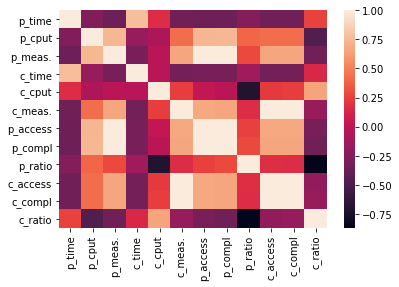

In [72]:
sns.heatmap(onlyResultsForBuffer.corr())

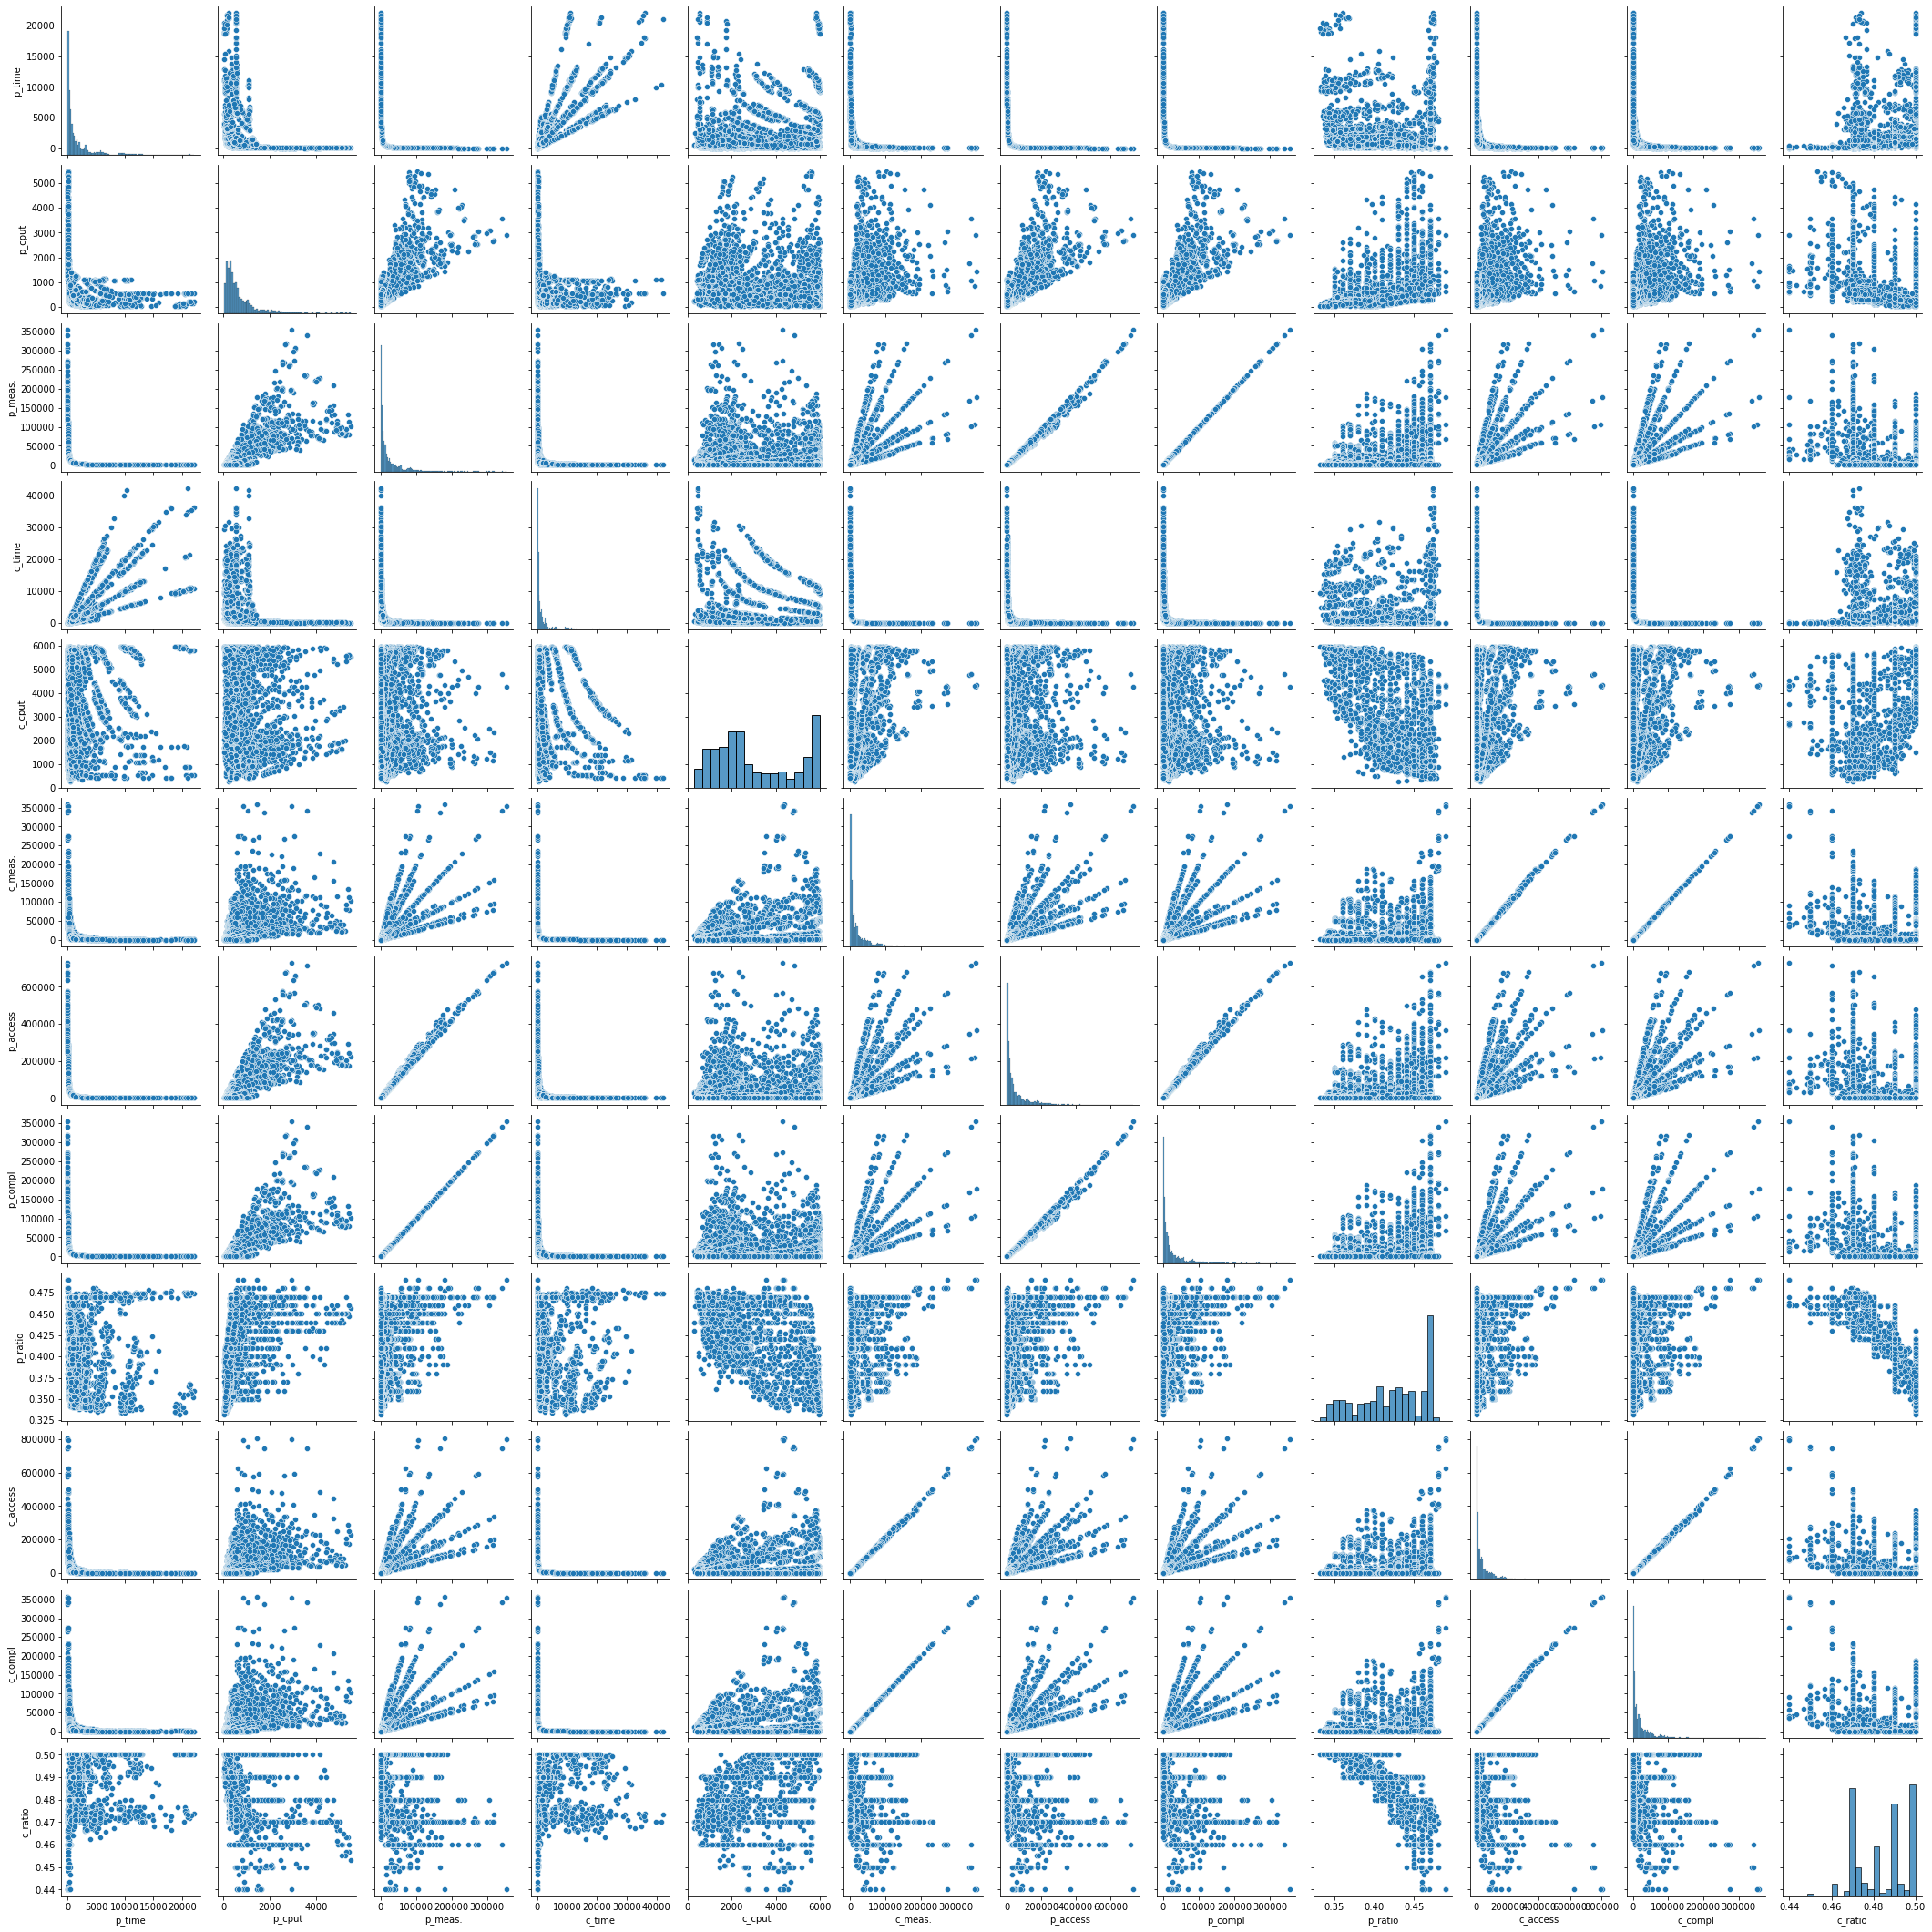

In [69]:
sns.pairplot(onlyResultsForBuffer)

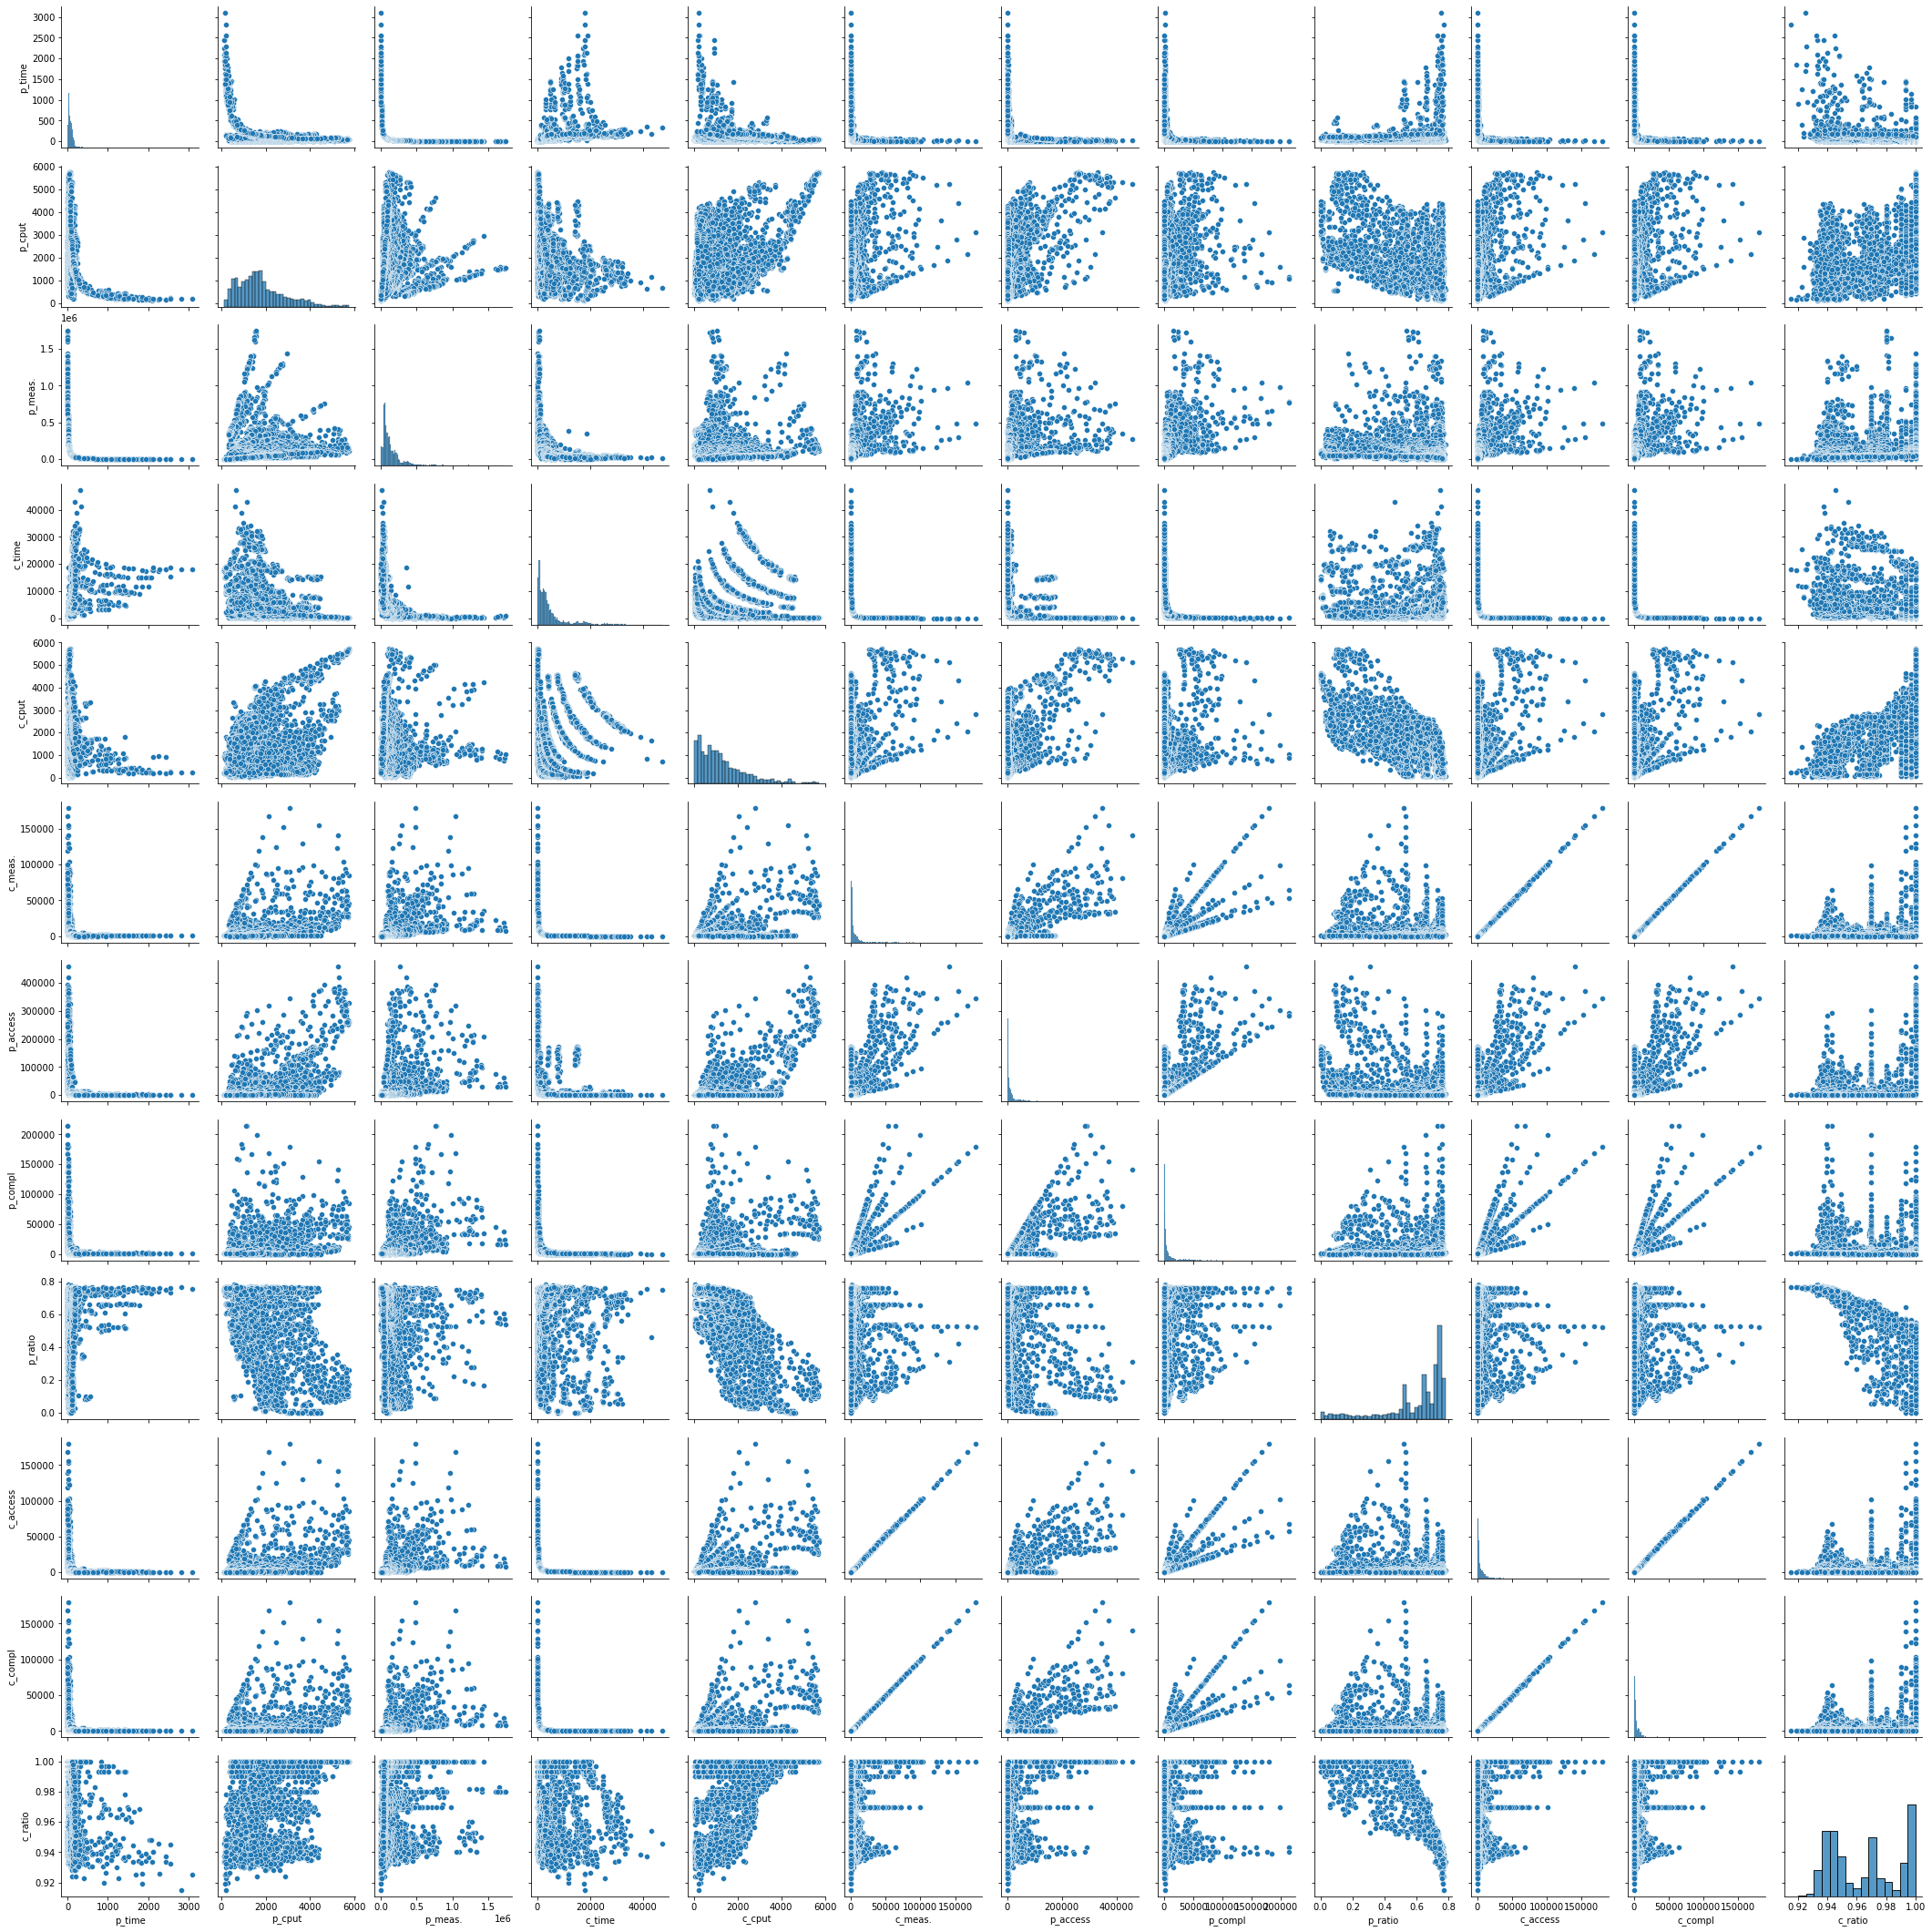

In [73]:
sns.pairplot(onlyResultsForActObject)

In [318]:
queryMainData = lambda dataframe: dataframe.query('p_numb == 3')\
                                           .query('c_numb == 3')\
                                           .query('complReqOptNumbCoeff == 100')\
                                           .query('bufferSize == 100')

In [319]:
measuresBuffer = queryMainData(measuresBufferFull)
measuresActObject = queryMainData(measuresActObjectFull)

In [320]:
hue='p_time'
param2 = 'actionCostCoeff'
param1 = 'optNumbCoeff'

annot=False

pivotedForBuffer = pd.pivot_table(measuresBuffer, values=hue, 
                     index=[param1], 
                     columns=param2)
pivotedForActObject = pd.pivot_table(measuresActObject, values=hue, 
                     index=[param1], 
                     columns=param2)

[Text(0.5, 1.0, 'p_time')]

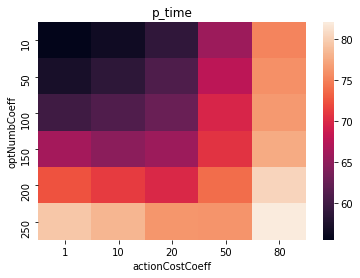

In [321]:
sns.heatmap(pivotedForBuffer, annot=annot).set(title=hue)


[Text(0.5, 1.0, 'p_time')]

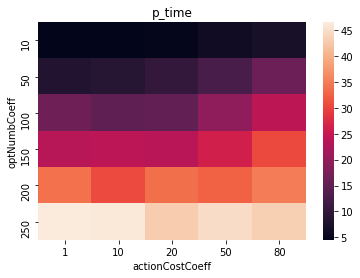

In [322]:
sns.heatmap(pivotedForActObject, annot=annot).set(title=hue)

[Text(0.5, 1.0, 'p_times actObj vs monitr ratio')]

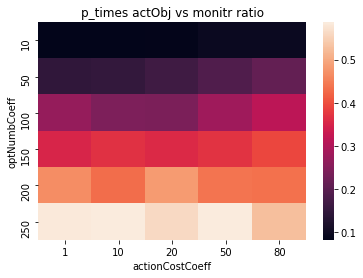

In [323]:
sns.heatmap(pivotedForActObject / pivotedForBuffer, annot=annot).set(title=hue + "s actObj vs monitr ratio")

In [324]:
def sub_plot_per_workers(index, columns, values, **kwargs):
    data = pd.DataFrame()
    data['index'] = index
    data['columns'] = columns
    data['values'] = values
    pivotedDataFrame = pd.pivot_table(data, values='values', 
                     index=['index'], 
                     columns='columns')
    sns.heatmap(pivotedDataFrame, annot=annot).set(title=hue)

In [325]:
queryData = lambda dataframe: dataframe.query('complReqOptNumbCoeff == 200')\
                                       .query('bufferSize == 100')

In [326]:
dataForByWorkersNumbersForBuffer = queryData(measuresBufferFull)
dataForByWorkersNumbersForActObject = queryData(measuresActObjectFull)

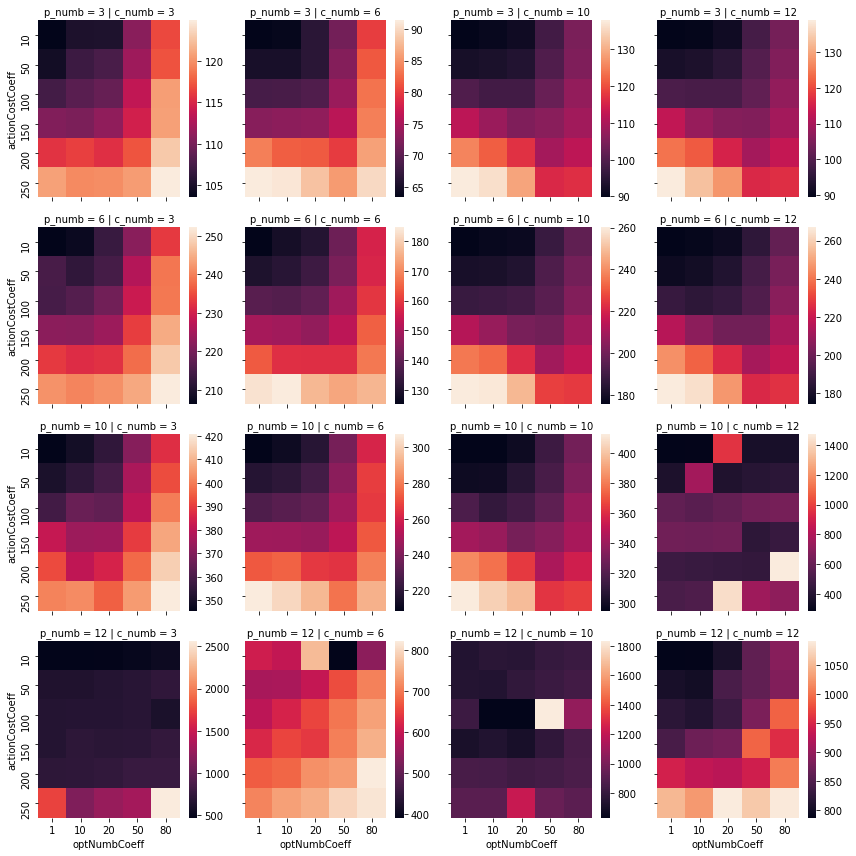

In [329]:
g = sns.FacetGrid(dataForByWorkersNumbersForBuffer, row='p_numb', col='c_numb').set(title=hue)
g.map(sub_plot_per_workers, param1, param2, hue)

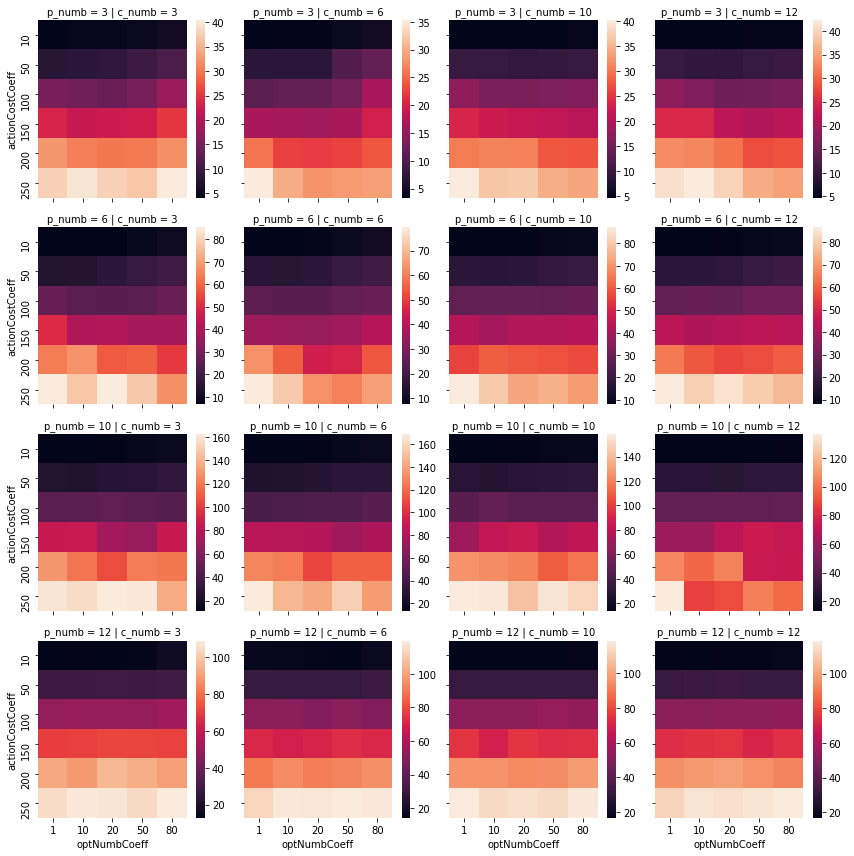

In [330]:
g = sns.FacetGrid(dataForByWorkersNumbersForActObject, row='p_numb', col='c_numb').set(title=hue)
g.map(sub_plot_per_workers, param1, param2, hue)